# Amex fraud prediciton project:

### In this project American Express provided tons of data in order to build a fraud prediciton model, the itention of this notebook attachded to Kedro is to do more free data exploration and test "pre-node" scripts, like data pipelines, models, etc.

# Imports

In [1]:
# Basic imports
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np

# Ml and FE imports
from scipy import stats
import lightgbm as lgb

# Magic load kedro
%load_ext kedro.extras.extensions.ipython

2022-07-06 08:46:41,281 - kedro.extras.extensions.ipython - INFO - Updated path to Kedro project: C:\Users\PedroMiyasaki\OneDrive - DHAUZ\Área de Trabalho\Projetos\PESSOAL\kaggle\americanExpress\Kadro
2022-07-06 08:46:43,580 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-07-06 08:46:45,165 - kedro.framework.hooks.manager - INFO - Registered hooks from 1 installed plugin(s): kedro-mlflow-0.11.0
2022-07-06 08:46:45,890 - kedro.extras.extensions.ipython - INFO - ** Kedro project kaggle
2022-07-06 08:46:45,890 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-07-06 08:46:49,208 - kedro.extras.extensions.ipython - INFO - Registered line magic `run_viz`
2022-07-06 08:46:49,208 - kedro.extras.extensions.ipython - INFO - Registered line magic `reload_kedro_mlflow`


# Functions

In [20]:
# Correlation betwen binary and continuous distributions functions
def bisserialCorr(data, x, binarY):
  # convert both variables to arrays
  xArray = np.array(data[x], dtype=int).ravel()
  binarYArray = np.array(data[binarY], dtype=int).ravel()
  
  # return biseralCorr
  return stats.pointbiserialr(binarYArray, xArray)

def kruskalDiffTest(data, x, binarY):
  # take the two numpy arrays, one where the variable is one, and one where the variable is 0
  xClass_0 = np.array(data.query(f"{binarY} == 0")[x], dtype=int).ravel()
  xClass_1 = np.array(data.query(f"{binarY} == 1")[x], dtype=int).ravel()
  
  return stats.kruskal(xClass_0, xClass_1)

def bivariateTest(data, x, binarY, showOnly=False):
  # Make biserial correlation and kruskal hypthothesis test
  biserial = biserialCorr(data, x, binarY)
  kruskal = kruskalDiffTest(data, x, binarY)
  
  # if the user only wants toi print the values
  if showOnly:
    print(f"Biserial Correlation Result: {biserial}")
    print(f"Kruskal Diff Result: {kruskal}")
    
    return None
  
  return biserial, kruskal

def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def fillna_with_lgb(data:pd.DataFrame, train_set_cols: list, col_to_fill: str) -> pd.DataFrame:
    # Instantiate lightgbm
    lg = lgb.LGBMRegressor(max_depth=-1, learning_rate=0.1, n_estimators=300)

    # Filter dataframe where variable to fill is not null
    dataNotNull = data.loc[~data[col_to_fill].isnull()]

    # Make X and Y
    X = dataNotNull[train_set_cols]
    Y = dataNotNull[col_to_fill]

    # Train the model
    lg.fit(X, Y)

    # Predict null values
    X_VAL = data[train_set_cols].loc[data[col_to_fill].isnull()]
    data.loc[data[col_to_fill].isnull(), col_to_fill] = lg.predict(X_VAL)

    return data

# Data loading

loading the train joined data, wich is te size optimezed train, with labels

In [2]:
#%reload_kedro
xtr = catalog.load("xtr")
ytr = catalog.load("ytr")

2022-07-06 08:47:01,244 - kedro.io.data_catalog - INFO - Loading data from `xtr` (FeatherDataSet)...
2022-07-06 08:47:01,663 - kedro.io.data_catalog - INFO - Loading data from `ytr` (FeatherDataSet)...


In [3]:
params = {'n_estimators': 10000, 'learning_rate': 0.2990893061199296, 
        'num_leaves': 2220, 'max_depth': 11, 
        'min_data_in_leaf': 7300, 'max_bin': 228, 
        'lambda_l1': 30, 'lambda_l2': 0, 'min_gain_to_split': 2.371217658457296, 
        'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}

lgbm = lgb.LGBMClassifier(**params)
lgbm.fit(xtr, ytr)

c:\Users\PedroMiyasaki\anaconda3\envs\kaggle\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\PedroMiyasaki\anaconda3\envs\kaggle\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=2.371217658457296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.371217658457296
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.9,
               lambda_l1=30, lambda_l2=0, learning_rate=0.2990893061199296,
               max_bin=228, max_depth=11, min_data_in_leaf=7300,
               min_gain_to_split=2.371217658457296, n_estimators=10000,
               num_leaves=2220)

# Data Size

In [38]:
df.shape

(5531451, 191)

# Data Types

Write the type, names, and example of the columns records to a simple txt file, to facilitate correct type analysis

All data types look right

In [ ]:
# Lets do a relatory to see if everthing is right

relatory = {}

for column in df.columns:
    # Make empty dict for column key
    relatory[column] = {}

    # Assign name
    relatory[column]["name"] = column

    # Assign type
    relatory[column]["type"] = df[column].dtype

    # Assign exampes
    relatory[column]["examples"] = df[column].sample(5)


for col in df.columns:
    with open("report.txt", "a") as writer:
        writer.write(str(relatory[col]))
        writer.write("======" * 100)

# Data Cleaning

How I"m gonna fill up the null values?

* Cat -> Use simple imputer most frequent
* Num -> Use all note null numeric cols to build a model that predicts nan values

In [7]:
# Take all nan count in numeric cols
numericalCols = df.select_dtypes(np.number).columns
nullSeries = df[numericalCols].isnull().sum()

In [8]:
# Take columns to train and columns to fill null"s
noneNullCols = nullSeries.loc[nullSeries == 0].index.tolist()
noneNullCols.remove("target")
nullCols =  nullSeries.loc[nullSeries > 0].index.tolist()

# Decriptive Analysis

## Light GBM

In [73]:
# Lading train, and test
xtr = catalog.load("x_train")
xval = catalog.load("x_val")
ytr = catalog.load("y_train")
yval = catalog.load("y_val")

2022-06-24 20:47:25,382 - kedro.io.data_catalog - INFO - Loading data from `x_train` (FeatherDataSet)...
2022-06-24 20:47:27,545 - kedro.io.data_catalog - INFO - Loading data from `x_val` (FeatherDataSet)...
2022-06-24 20:47:27,996 - kedro.io.data_catalog - INFO - Loading data from `y_train` (FeatherDataSet)...
2022-06-24 20:47:28,016 - kedro.io.data_catalog - INFO - Loading data from `y_val` (FeatherDataSet)...


In [33]:
# Instantiate lightgbm model
l = lgb.LGBMClassifier(num_leaves=95, max_depth=-1, learning_rate=0.02, n_estimators=1000)

# Fit the model
l.fit(xtr, ytr["target"])

LGBMClassifier(learning_rate=0.02, n_estimators=1000, num_leaves=95)

In [77]:
# Predict the yhat
xval["prediction"] = l.predict_proba(xval[[col for col in xtr.columns]])[:, 1]
xval["target"] = yval["target"]

# Calculate the metrics
metrics = {
    "kaggle": amex_metric(y_true=pd.DataFrame(xval["target"]), y_pred=pd.DataFrame(xval["prediction"])),
}

metrics["kaggle"]

0.7827143149657629

## Outliers Analysis

Lets analyse the outliers in the target most correlated columns

The outliers are very important, this is expected in the context of "Fraud detection" problems, so, they will be not capped out of the data on the training process, we will use a scaler to maintain them

In [22]:
# Take correlations
correlations = {
    "variable": [],
    "correlation": []
    }

for variable in df.columns:
    correlations["variable"].append(variable)
    correlations["correlation"].append(bisserialCorr(data=df, x=variable, binarY="target")[0])


correlations = pd.DataFrame(correlations)

c:\Users\PedroMiyasaki\anaconda3\envs\kaggle\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


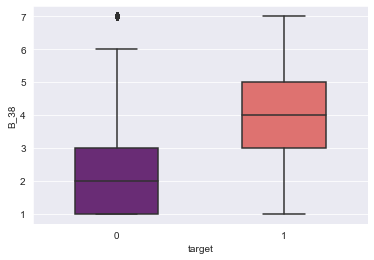

In [32]:
ax = sns.boxplot(data=df, y="B_38", width=0.5, x="target", palette="magma")

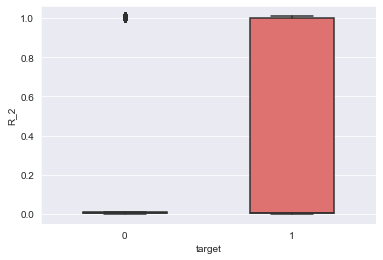

In [33]:
ax = sns.boxplot(data=df, y="R_2", width=0.5, x="target", palette="magma")

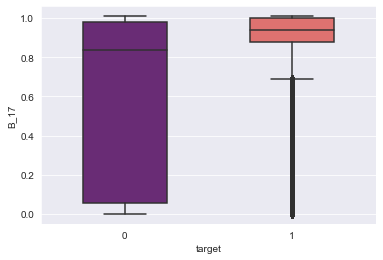

In [34]:
ax = sns.boxplot(data=df, y="B_17", width=0.5, x="target", palette="magma")

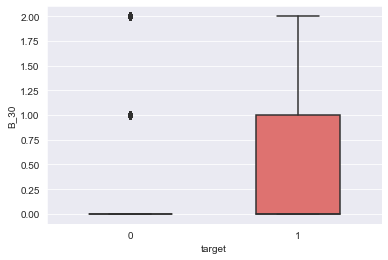

In [35]:
ax = sns.boxplot(data=df, y="B_30", width=0.5, x="target", palette="magma")

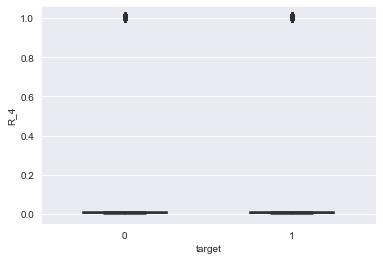

In [36]:
ax = sns.boxplot(data=df, y="R_4", width=0.5, x="target", palette="magma")

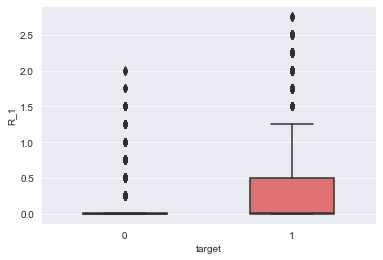

In [37]:
ax = sns.boxplot(data=df, y="R_1", width=0.5, x="target", palette="magma")

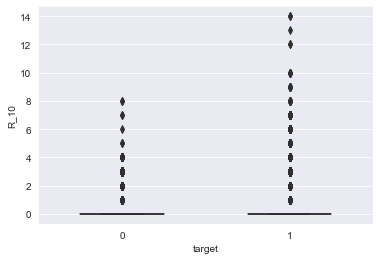

In [38]:
ax = sns.boxplot(data=df, y="R_10", width=0.5, x="target", palette="magma")